In this notebook, we look at how the PSD is impacted by the presence of the signal in the noise. So, we do the analysis for a PSD build when the PSD is build for data without signal (it has bee, subtracted). We also look at the behaviour of the analysis in the case where the noise is gaussian white noise and not detector noise. We also look at how the SNR evolves for a given event as function of the amplitude and type of noise that is present.

In [1]:
#installation of PYCB on computer
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/cytomine-uliege/Cytomine-python-client/pypi/simple
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pycbc.catalog import Merger
import matplotlib.pyplot as plt
m= Merger("GW170814")
ts_liv=m.strain('L1')


f=plt.figure()
plt.plot(ts_liv.sample_times, ts_liv, label='L1')
plt.xlabel('GPS time (s)')
plt.ylabel("Strain")
plt.title("Livingston data")


Text(0.5,1,'Livingston data')

Text(0,0.5,'Strain')

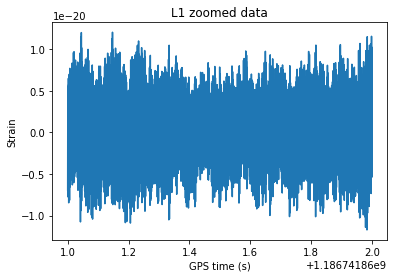

In [3]:
#highpass the data
high_data = ts_liv.highpass_fir(15,512)
zoom = high_data.time_slice(m.time-0.5, m.time+0.5)
plt.plot(zoom.sample_times, zoom)
plt.title("L1 zoomed data")
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")

Here we make the PSD of the noise when the signal is present. This is the same as what has been done in the typical analysis. It is needed here in order to be able to model and subtract the signal.

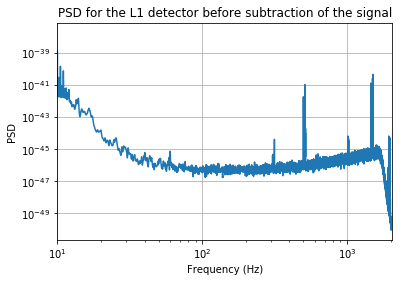

In [4]:
import numpy as np
from pycbc.psd import interpolate, inverse_spectrum_truncation

f_low = 20
f_up = 1024


psd = ts_liv.psd(4)
psd = interpolate(psd, ts_liv.delta_f)
psd = inverse_spectrum_truncation(psd, 4*ts_liv.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

#plot of the PSD
plt.loglog(fs, psd)
plt.xlim(10, 2048)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD for the L1 detector before subtraction of the signal")
plt.grid()

Now, we do the analysis as has been done before in order to subtract the signal out of the data and see how the PSD change

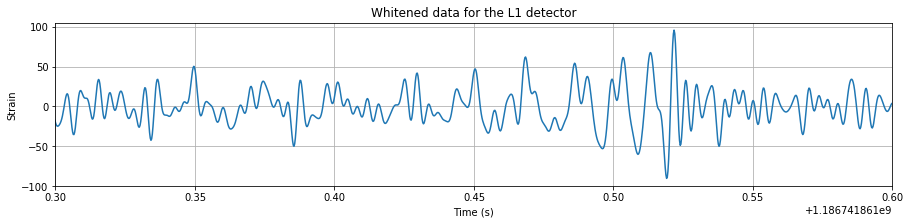

In [5]:
# Whiten the data 
white_data = (ts_liv.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30,512).lowpass_fir(300,512)
white_data = white_data.time_slice(m.time-0.2,m.time+0.2)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data)
plt.xlim(m.time-.2, m.time+.1)
plt.xlabel('Time (s)')
plt.ylabel("Strain")
plt.title('Whitened data for the L1 detector')
plt.grid()

In [6]:
from pycbc import filter
from pycbc.types import Array

from pycbc.waveform import get_td_waveform

In [7]:
def gen_template(theta,
                 delta_t=ts_liv.delta_t,
                 duration=ts_liv.duration,
                 start_time=ts_liv.start_time,
                 f_lower=f_low):
    
    m1, m2, distance, inclination, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=-0.568797,
                             spin2z=0.13079314,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - ts_liv.start_time)
    hp.start_time = ts_liv.start_time

    return hp

In [8]:
df = ts_liv.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_low, f_upper=f_up):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_low, f_up, df.delta_f, (N - 1) * 2)

    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    logl = -0.5*(hh - 2.0*dh)

    return logl

In [9]:
def whiten_trim_template(template, psd=psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_template = white_template.time_slice(m.time-.2, m.time+.1)
    return white_template

def plot_whitened_strains(ts_liv, template):
    white_data = (ts_liv.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_data = white_data.time_slice(m.time-.2, m.time+.1)
    white_template = white_template.time_slice(m.time-.2, m.time+.1)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(m.time-.2, m.time+.1)
    plt.legend()

-71.14832259267129


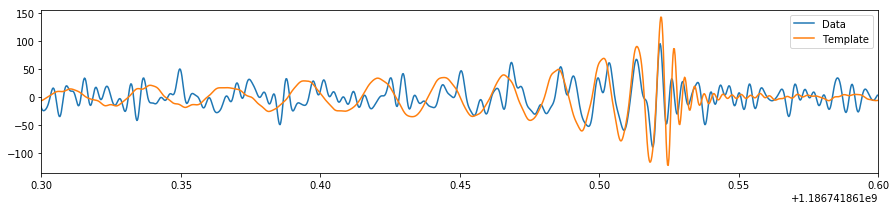

In [10]:
theta0 = [31., 25., 580.,0.6, float(m.time)+0.025,0]

template0 = gen_template(theta0)
plot_whitened_strains(ts_liv, template0)

print(loglikelihood(theta0))

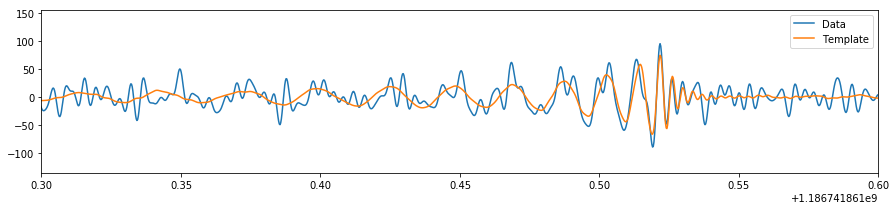

Steps	log(likelihood)
7	85.028


In [11]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim_template(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label="Data")
line, = plt.plot(whitened_template.sample_times, whitened_template, label="Template")

plt.xlim(m.time-.2, m.time+.1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

[ 3.11252946e+01  2.50014200e+01  1.30050864e+03  3.26998715e-06
  1.18674186e+09 -3.78870288e-01]


Text(0.5,1,'Whitened strain and template for the L1 detector')

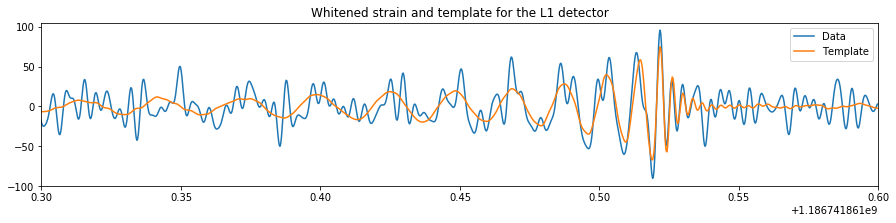

In [12]:
best_fit = res.x
best_fit_template = gen_template(best_fit)
print(best_fit)
plot_whitened_strains(ts_liv, best_fit_template)
plt.title("Whitened strain and template for the L1 detector")

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


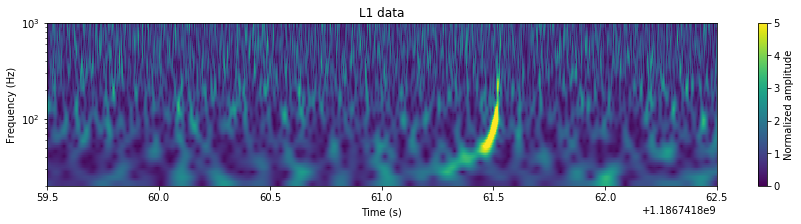

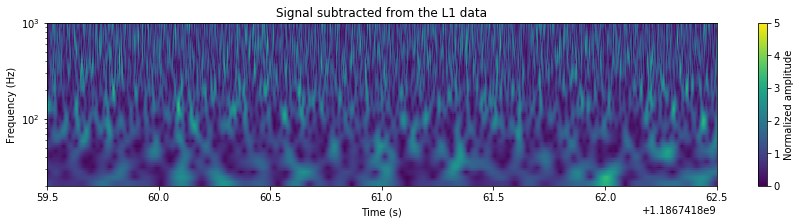

In [13]:
sub_data = ts_liv - best_fit_template

# plot the original data

for data, title in [(ts_liv, 'L1 data'), 
                    (sub_data, 'Signal subtracted from the L1 data')]:
    t, f, p = data.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    im=plt.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(m.time - 2, m.time + 1)
    plt.ylim(0,1000)
    cbar=plt.colorbar()
    cbar.ax.set_ylabel("Normalized amplitude")

Now that we see that the signal has well been subtracted, we can compute the PSD for this subtracted data. This new PSD can than be computed again and compared with the one that has been computed first. After that, we can redo the analysis to see if there is a significant difference.

First, we plot the data thta is obtained with the subtraction of the signal that has been done.

In [14]:
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

Text(0,0.5,'Strain')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


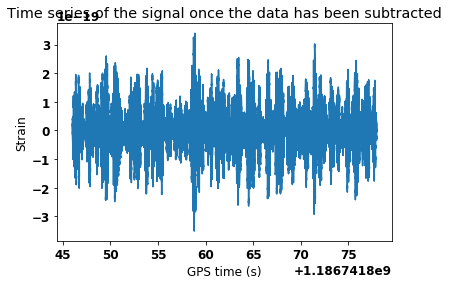

In [15]:
plt.plot(sub_data.sample_times, sub_data)
plt.title("Time series of the signal once the data has been subtracted")
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")

Text(0,0.5,'Strain')

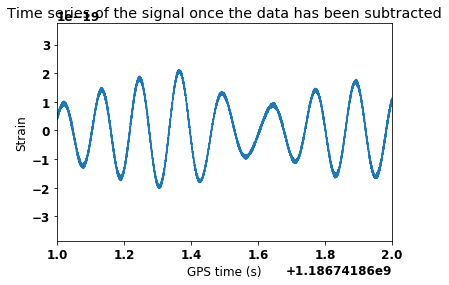

In [16]:
#because there is nothing that seems very obvious, we can zoom around the
#time of the event in order to see what happens there

plt.plot(sub_data.sample_times, sub_data)
plt.xlim(m.time-0.5, m.time+0.5)
plt.title("Time series of the signal once the data has been subtracted")
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")

There is no way to really see what is the difference for the signal...

Now, we try to see how we can make PSD based on this signal, before redoing the analysis based on this new PSD

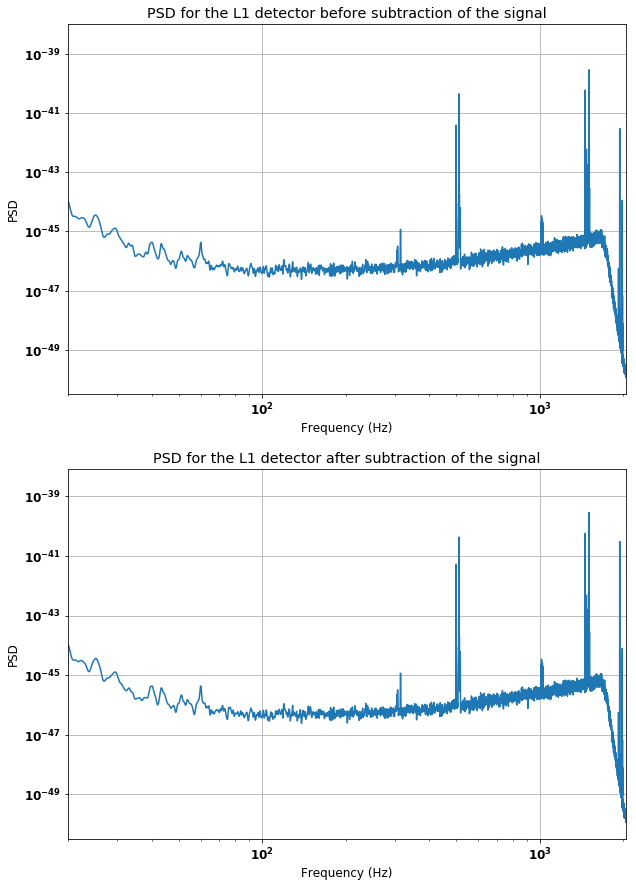

In [17]:
f_low = 20
f_up = 1024

fig=plt.figure(figsize=[10,15])
ax=fig.subplots(nrows=2)


psd = ts_liv.psd(2)
psd = interpolate(psd, ts_liv.delta_f)
psd = inverse_spectrum_truncation(psd, 2*ts_liv.sample_rate, low_frequency_cutoff=15.)

fs = psd.delta_f * np.arange(psd.data.size)

#plot of the PSD
ax[0].loglog(fs, psd)
ax[0].set_xlim(20, 2048)
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("PSD")
ax[0].set_title("PSD for the L1 detector before subtraction of the signal")
ax[0].grid()

psd_sub = sub_data.psd(2)
psd_sub = interpolate(psd_sub, sub_data.delta_f)
psd_sub = inverse_spectrum_truncation(psd_sub, 2*sub_data.sample_rate, low_frequency_cutoff=15.)

fs_sub = psd_sub.delta_f * np.arange(psd_sub.data.size)

ax[1].loglog(fs_sub, psd_sub)
ax[1].set_xlim(20, 2048)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("PSD")
ax[1].set_title("PSD for the L1 detector after subtraction of the signal")
ax[1].grid()

Text(0.5,1,'Superposition of the PSD for the L1 detector before and after the signal has been subtracted')

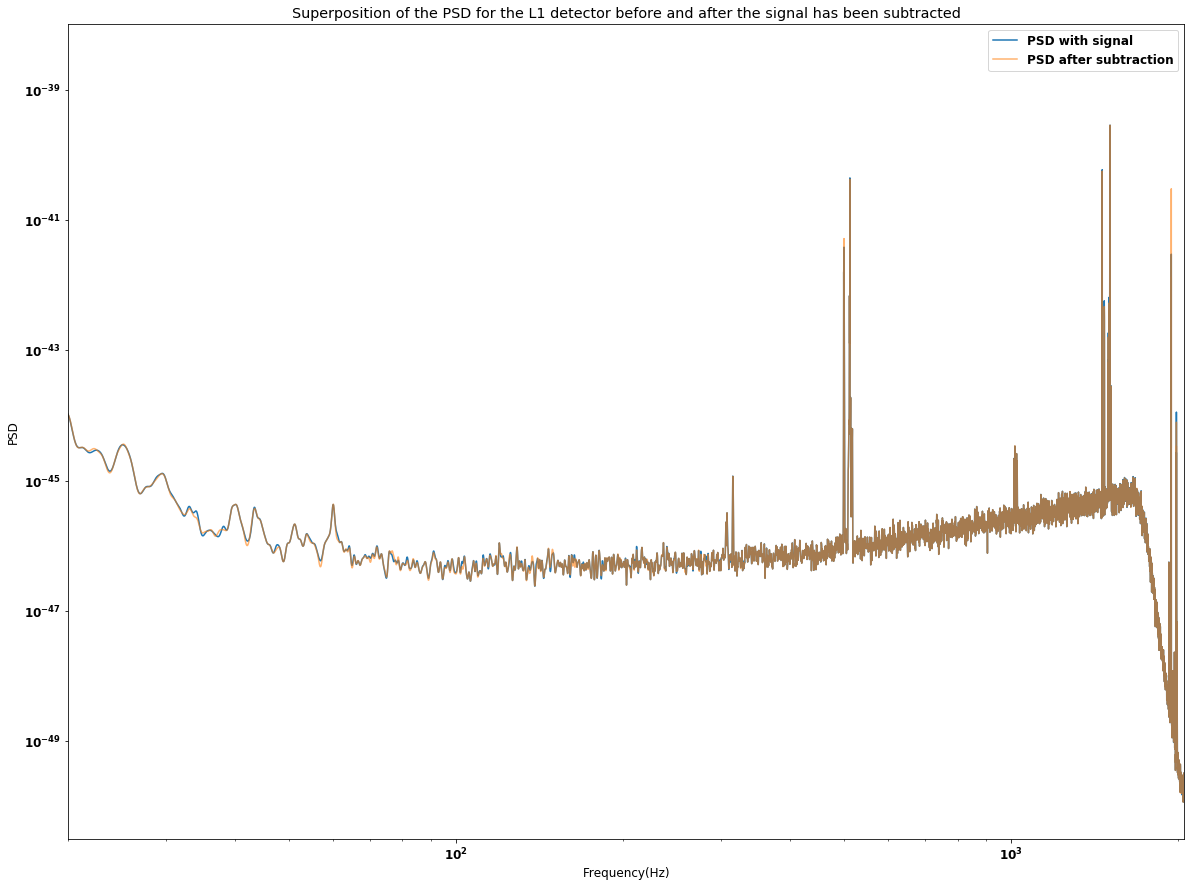

In [18]:
#superposition of both in order to see if there is a small difference
plt.figure(figsize=[20,15])
plt.loglog(fs, psd, alpha=1, label="PSD with signal")
plt.loglog(fs_sub, psd_sub, alpha=0.6, label="PSD after subtraction")
plt.xlim(20,2048),
plt.xlabel("Frequency(Hz)")
plt.ylabel("PSD")
plt.legend(loc='best')
plt.title("Superposition of the PSD for the L1 detector before and after the signal has been subtracted")

There exist small changes at some places. This is seen when zooming onto the plot. We also see that some peaks are less high and other are higher, which shows that the subtraction has an effect, even if the difference is rather small.

Now, we can look if it does make a difference on the analysis, with different parameters and see if we have a high SNR or not.

/home/justin/.local/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'Model of the waveform used')

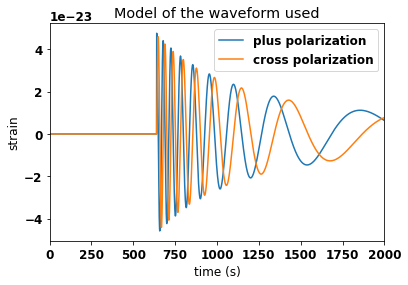

In [19]:
#we use the same template than the one that has been used in the original 
#in order to be able to compare both resultst concerning the data SNR and 
#the signififance etc.


from pycbc.waveform import get_fd_waveform

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=ts_liv.delta_f, f_final=739.0645)
hp.resize(len(psd_sub))
hf.resize(len(psd_sub))
template = hp.cyclic_time_shift(hp.start_time)
temp_cross = hf.cyclic_time_shift(hf.start_time) 
plt.plot(template, label="plus polarization")
plt.plot(temp_cross, label="cross polarization")
plt.legend(loc="best")
plt.xlim(0,2000)
plt.ylabel("strain")
plt.xlabel("time (s)")
plt.title("Model of the waveform used")

We found a signal at 1186741861.5244141s with a SNR of 13.3264041 in the Livingston detector


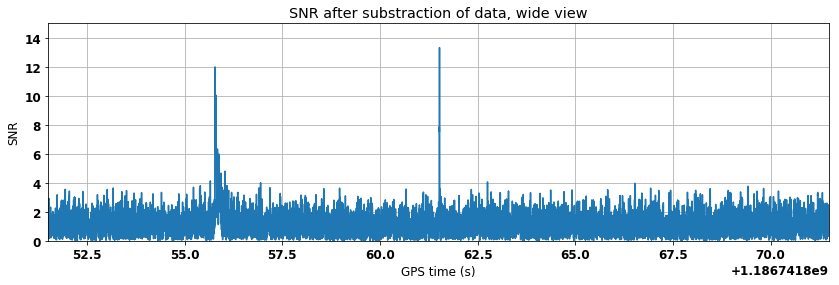

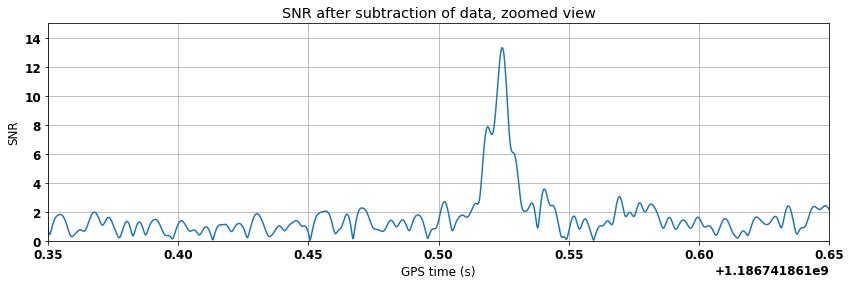

In [20]:
from pycbc.filter import matched_filter
snr = matched_filter(template, ts_liv, psd=psd_sub, low_frequency_cutoff=20)
snr = snr.crop(5, 4)
for w, title in [(10, 'SNR after substraction of data, wide view'), (.15, 'SNR after subtraction of data, zoomed view')]:
    plt.figure(figsize=[14,4])
    if(w==10):
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]
        print("We found a signal at %.7fs with a SNR of %.7f in the Livingston detector" %(time, abs(snrp)))
    plt.plot(snr.sample_times, abs(snr))
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("GPS time (s)")
    plt.ylabel("SNR")

At first view, the SNR seems more important than in the previous case. Howeer, in order to check that, we will compute it based on the PSD with the signal included and compare both in one graph.

We found a signal at 1186741861.5244141s with a SNR of 13.3264041 in the Livingston detector


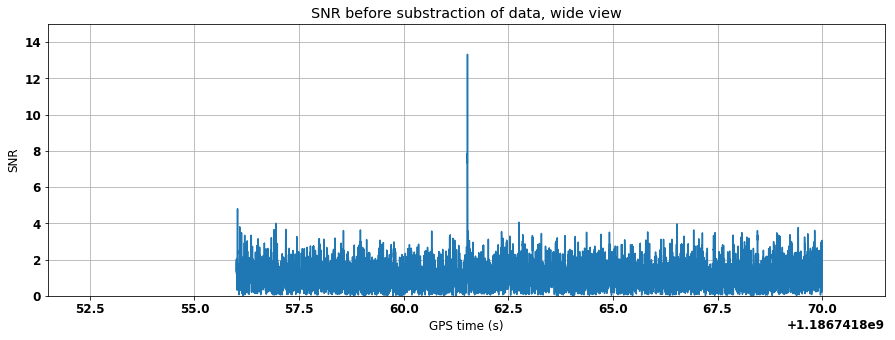

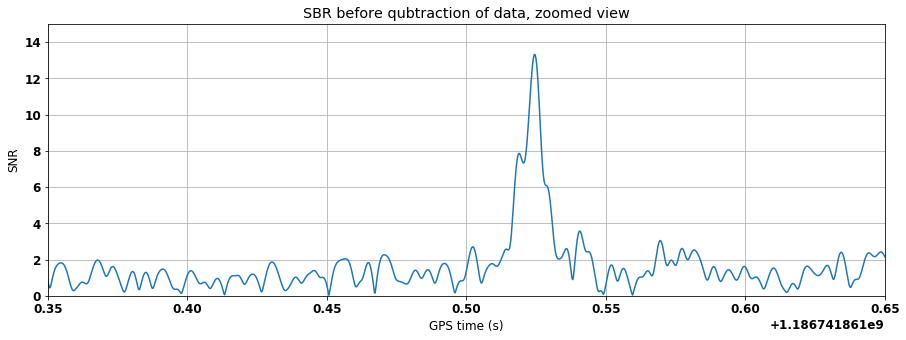

In [21]:

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=ts_liv.delta_f, f_final=739.0645)
hp.resize(len(psd))
hf.resize(len(psd))
template = hp.cyclic_time_shift(hp.start_time)
temp_cross = hf.cyclic_time_shift(hf.start_time) 

snr_original = matched_filter(template, ts_liv, psd=psd, low_frequency_cutoff=20)
snr_original = snr.crop(5, 4)
for w, title in [(10, 'SNR before substraction of data, wide view'), (.15, 'SBR before qubtraction of data, zoomed view')]:
    plt.figure(figsize=[15,5])
    if(w==10):
        peak = abs(snr_original).numpy().argmax()
        snrp = snr_original[peak]
        time = snr_original.sample_times[peak]
        print("We found a signal at %.7fs with a SNR of %.7f in the Livingston detector" %(time, abs(snrp)))
    plt.plot(snr_original.sample_times, abs(snr_original))
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("GPS time (s)")
    plt.ylabel("SNR")

So far, I am not convinced. It seems like there is no difference ar all between both. To further check that, I will do the analysis of the GW 170814 event compltely for the 3 detector as had been done before. 

In [22]:
from pycbc.catalog import Merger
m= Merger("GW170814")
ts_han=m.strain('H1')
ts_liv=m.strain('L1')
ts_vir=m.strain('V1')

print("Duration: {}s Start: {} End: {}".format(ts_han.duration, 
                                              int(ts_han.start_time),
                                              int(ts_han.end_time)))

data={}
for i in ['L1','H1','V1']:
    data[i]=m.strain(i)

sub_data={}
for i in ['L1', 'H1', 'V1']:
    sub_data[i]=data[i]-best_fit_template


Duration: 32.0s Start: 1186741846 End: 1186741878


(1186741861.2, 1186741861.8)

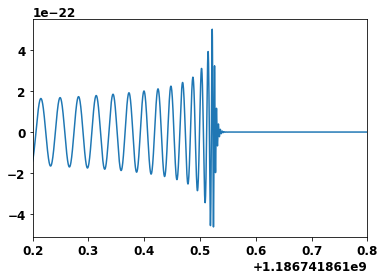

In [23]:
#plot of the best_fit_template
plt.plot(best_fit_template.sample_times, best_fit_template)
plt.xlim(m.time-0.3, m.time+0.3)

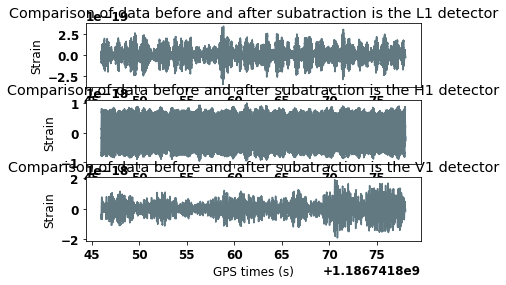

In [24]:
f=plt.figure()
ax=f.subplots(nrows=3)
j=0
for i in ['L1','H1','V1']:
    ax[j].plot(data[i].sample_times, data[i],alpha=1, label="original data")
    ax[j].plot(sub_data[i].sample_times, data[i], alpha=0.3, label="subtracted data")
    ax[j].set_xlim=(m.time-0.3, m.time+0.2)
    ax[j].set_title("Comparison of data before and after subatraction is the %s detector" %i)
    ax[j].set_xlabel("GPS times (s)")
    ax[j].set_ylabel("Strain")
    j+=1

In [25]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
import matplotlib.pyplot as plt

detec = ['L1','H1','V1']
datas={}
sub_datas={}

for det in detec:
    ts = m.strain(det).highpass_fir(15,512)
    datas[det] = resample_to_delta_t(ts, 1.0/2048)
    datas[det] = datas[det].crop(2,2)
    ts_sub = sub_data[det].highpass_fir(15,512)
    sub_datas[det] = resample_to_delta_t(ts_sub, 1.0/2048)
    sub_datas[det] = sub_datas[det].crop(2,2)
    
    

I have checked that there is a difference between the normal data and the subtracted data (at least for the L1 detector, which is the most important in what follows, as it is the one for which the template has been adjusted).

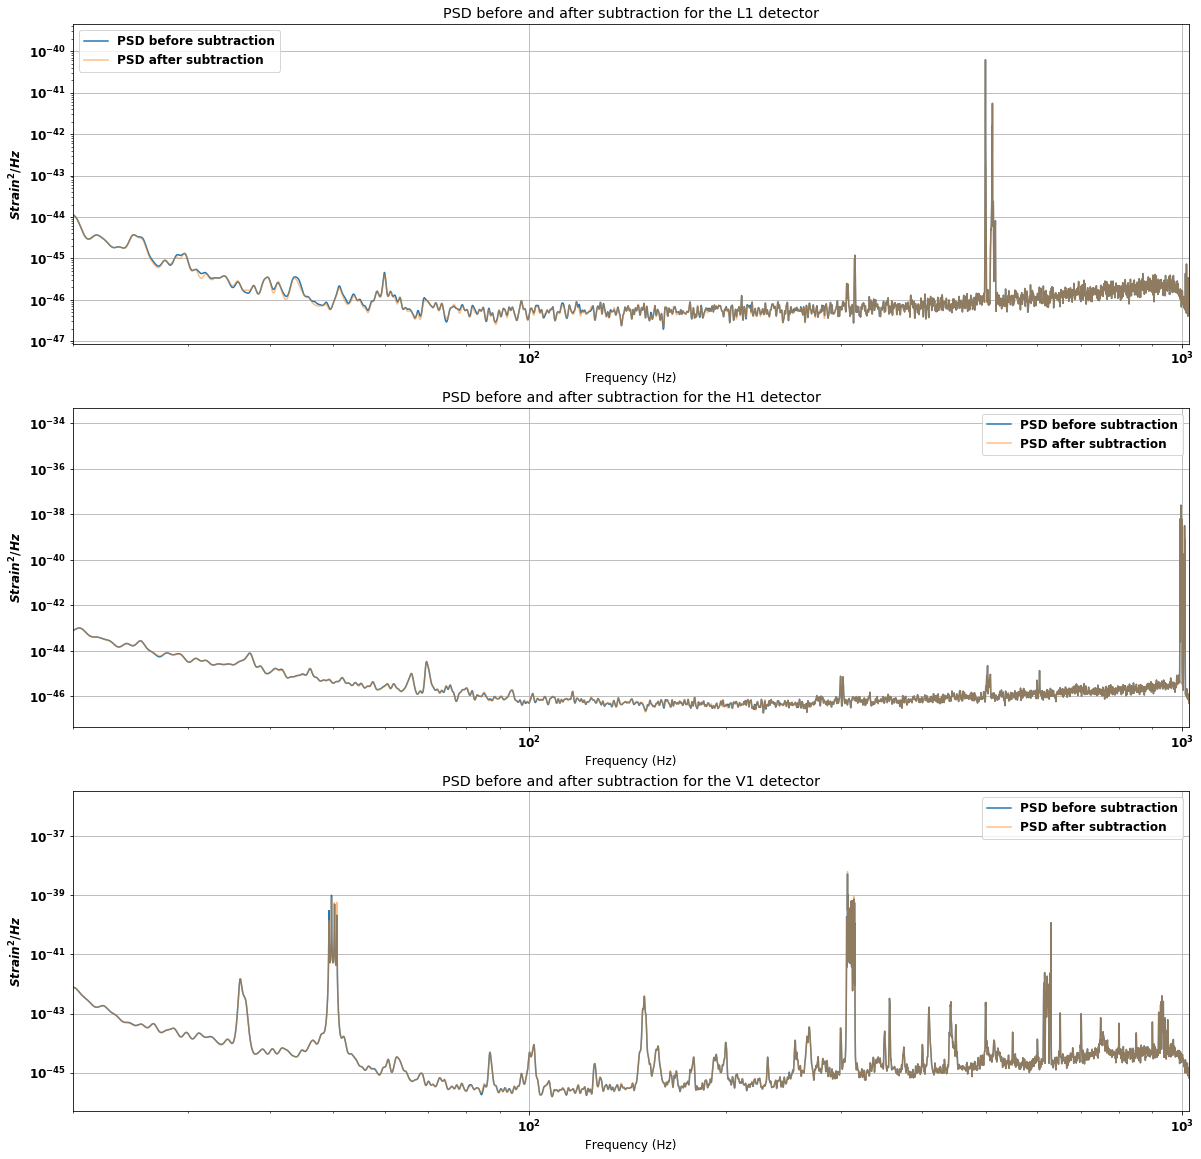

In [26]:
#making of the PSD before and after subtraction fir all the detectors

psd = {}
psd_sub = {}

f = plt.figure(figsize=[20,20])
ax = f.subplots(nrows = 3)

j=0

for det in detec:
    p = datas[det].psd(2)
    p = interpolate(p, datas[det].delta_f)
    p = inverse_spectrum_truncation(p, 2*datas[det].sample_rate, low_frequency_cutoff = 15.0)
    psd[det] = p
    
    p_sub = sub_datas[det].psd(2)
    p_sub = interpolate(p_sub, sub_datas[det].delta_f)
    p_sub = inverse_spectrum_truncation(p_sub, 2*sub_datas[det].sample_rate, low_frequency_cutoff = 15.0)
    psd_sub[det] = p_sub
    
    ax[j].loglog(psd[det].sample_frequencies, psd[det], alpha=1, label="PSD before subtraction")
    ax[j].loglog(psd_sub[det].sample_frequencies, psd_sub[det], alpha=0.5, label="PSD after subtraction")
    ax[j].set_xlim(20, 1024)
    ax[j].set_ylabel("$Strain^2 / Hz$")
    ax[j].set_xlabel("Frequency (Hz)")
    ax[j].grid()
    ax[j].legend(loc='best')
    ax[j].set_title("PSD before and after subtraction for the %s detector" %det)
    
    j+=1
    

Even if they are not that big, one sees that there is a difference between the 2 PSD for the different detectors

Text(0.5,1,'Model of the waveform used')

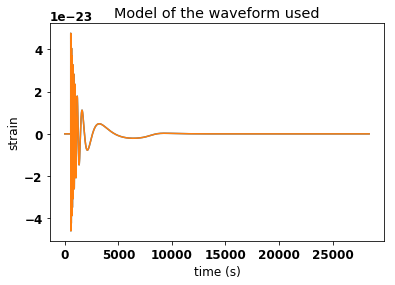

In [27]:
#build the two waveforms used for the SNR
from  pycbc.waveform import get_fd_waveform

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=datas[det].delta_f, f_final=739.0645)

hp1, hf1 = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=datas[det].delta_f, f_final=739.0645)

hp.resize(len(psd[det]))
hp1.resize(len(psd_sub[det]))
template = hp.cyclic_time_shift(hp.start_time)
template_sub = hp1.cyclic_time_shift(hp1.start_time)
plt.plot(template)
plt.plot(template_sub)
#plt.xlim(0,2000)
plt.ylabel("strain")
plt.xlabel("time (s)")
plt.title("Model of the waveform used")

Before subtraction, we found a signal at 1186741861.5244141s with a SNR of 13.0505848 in the L1 detector
After subtraction, we found a signal at 1186741861.5244141s with a SNR of 13.6407515 in the L1 detector
Before subtraction, we found a signal at 1186741861.5327148s with a SNR of 9.2115963 in the H1 detector
After subtraction, we found a signal at 1186741861.5327148s with a SNR of 9.2662704 in the H1 detector
Before subtraction, we found a signal at 1186741868.5644531s with a SNR of 5.4803894 in the V1 detector
After subtraction, we found a signal at 1186741868.5644531s with a SNR of 5.5127431 in the V1 detector


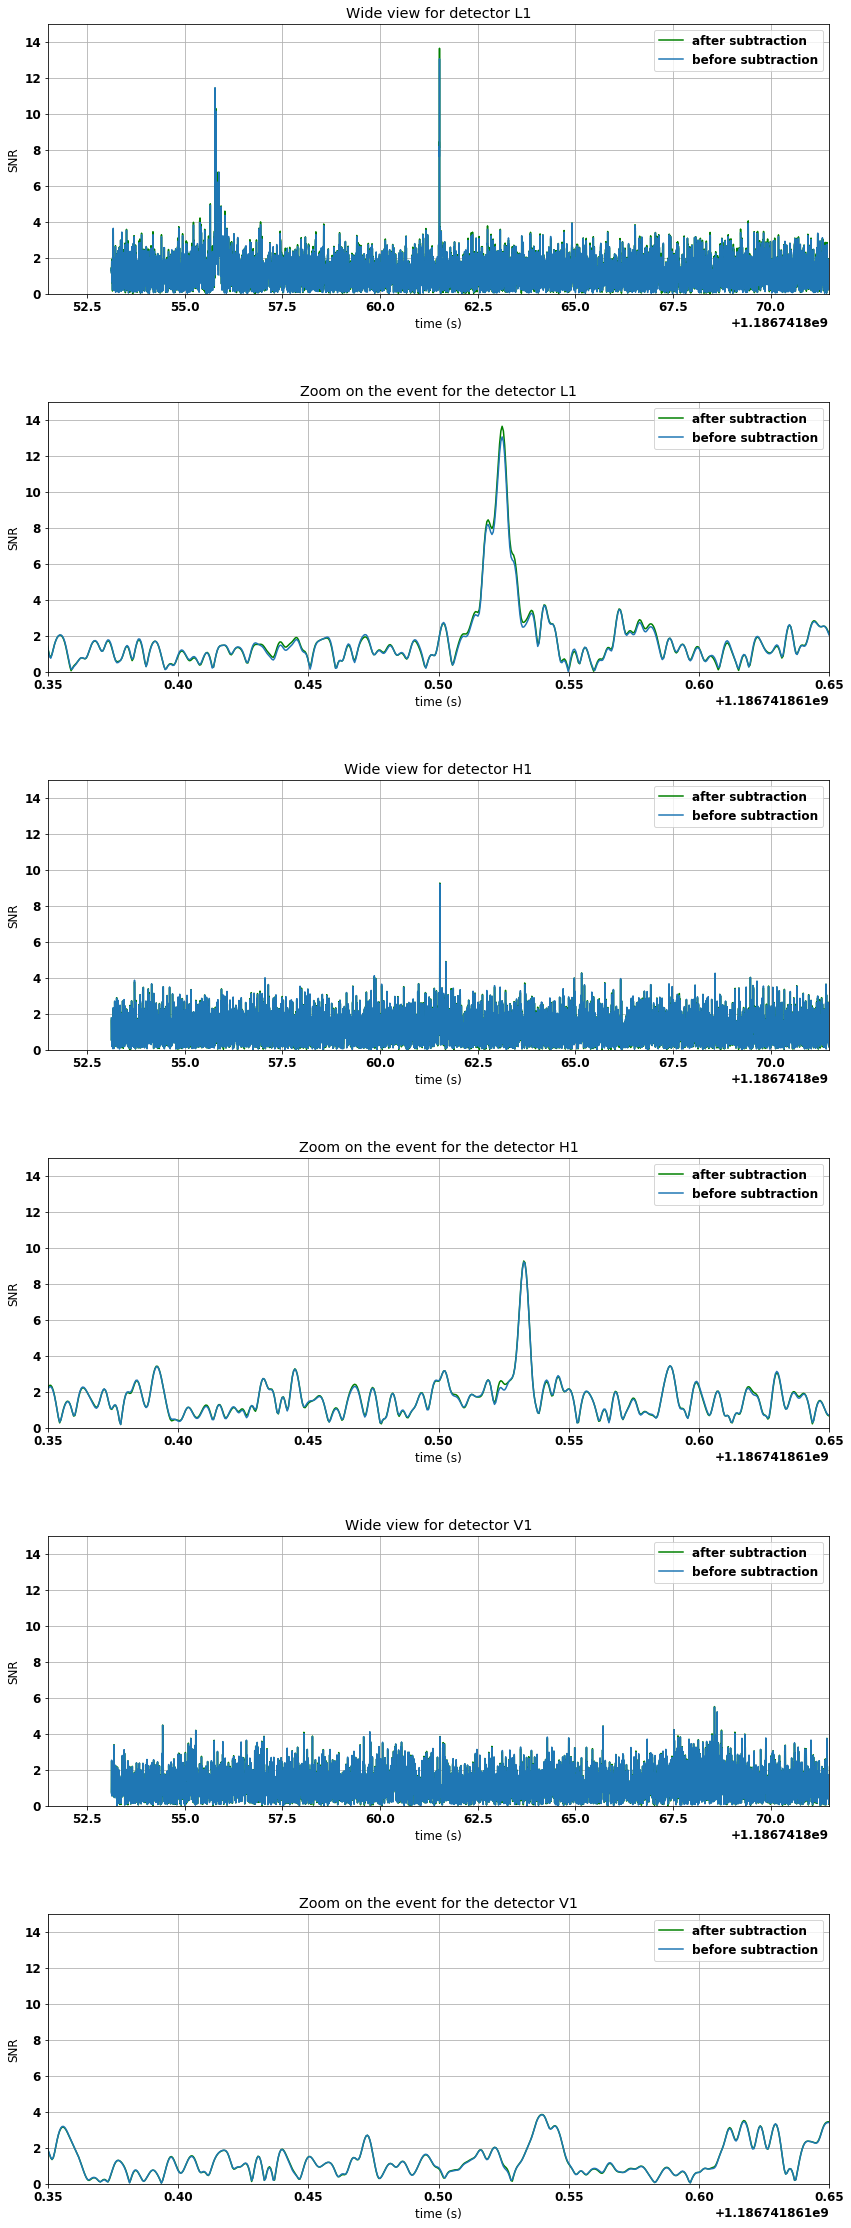

In [28]:
from pycbc.filter import matched_filter

snr={}
snr_sub = {}
peaks = {}
peaks_sub = {}
snrp = {}
snrp_sub = {}
times = {}
times_sub = {}

f = plt.figure(figsize=[14, 30])
f.subplots_adjust( bottom=15, top=16, wspace= 0.4, hspace=0.4)
ax = f.subplots(nrows = 6)

for i in detec:
    snr[i] = matched_filter(template, datas[i], psd=psd[i], low_frequency_cutoff = 15.)
    snr_sub[i] = matched_filter(template, datas[i], psd=psd_sub[i], low_frequency_cutoff = 15.)
    snr[i] = snr[i].crop(5,4)
    snr_sub[i] = snr_sub[i].crop(5,4)
    
j=0
for i in detec:
    for w, title in [(10, "Wide view for detector %s" %i), (.15,"Zoom on the event for the detector %s" %i)]:
        ax[j].plot(snr_sub[i].sample_times, abs(snr_sub[i]), color='green', label='after subtraction')
        ax[j].plot(snr[i].sample_times, abs(snr[i]), label="before subtraction")
        if(w==10):
            peaks[i] = abs(snr[i]).numpy().argmax()
            peaks_sub[i] = abs(snr_sub[i]).numpy().argmax()
            snrp[i] = snr[i][peaks[i]]
            snrp_sub[i] = snr_sub[i][peaks[i]]
            times[i] = snr[i].sample_times[peaks[i]]
            times_sub[i] = snr_sub[i].sample_times[peaks_sub[i]]
            print("Before subtraction, we found a signal at %.7fs with a SNR of %.7f in the %s detector" %(times[i], abs(snrp[i]), i))
            print("After subtraction, we found a signal at %.7fs with a SNR of %.7f in the %s detector" %(times_sub[i], abs(snrp_sub[i]), i))
        ax[j].legend(loc='best')
        ax[j].set_title(title)
        ax[j].grid()
        ax[j].set_xlim(m.time-w, m.time+w)
        ax[j].set_ylim(0,15)
        ax[j].set_xlabel("time (s)")
        ax[j].set_ylabel("SNR")
        j+=1
        
        
    

We see that there is a difference in the SNR that has been found since, with a difference of more or less 0.5 for the L1 detector. It is the one where the difference is the biggest as it is the one for which the template has been adjusted.


In the hypothesis of the matched filtering, one takes the noise is white. Therefore, here, we will compute the PSD of white noise that we first need to generate. After that, we can do two teste. Use it directly onto the data and add a GW signal to the white noise to see how well the technique works when the noise really is respecting the constraints that have been imposed.

In [29]:
#need to known the number of sample points that are present in the data
print(len(data['L1']))

131072


Because this is the lenght of the time series, in order to have something coherant with the other data, we generate a time series of white noise which enables to have as many points (131072). This corresponds to a sample of 4049 points for each second in the raw data.

**definition of white noise:** Gaussian white noise is a series of points that are all inpedendant and drown from the same random process. 

Here, because of the width of the strain that can be seen in the detector, we take that all the points are taken out of a gaussian centered on zero and with a width of 10e-18 (closest to the L1/H1 detector for the O2 run)

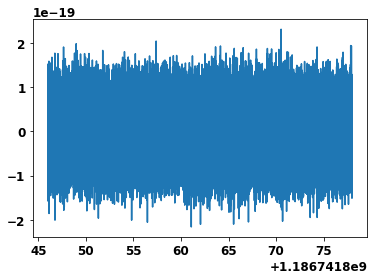

In [30]:
import numpy as np
import scipy
import scipy.stats
from pycbc.types import TimeSeries 
data = m.strain('L1')
#vector of the times that corresponds to those present in the 
#time series that are analyzed
times = data.sample_times
#fix the seed to keep the same noise present
np.random.seed(seed=12)
norm = scipy.stats.norm(0,0.5*10e-20)
white = norm.rvs(len(times))
white = TimeSeries(white, delta_t = 1.0/4096, epoch = data.start_time)
plt.plot(times, white)

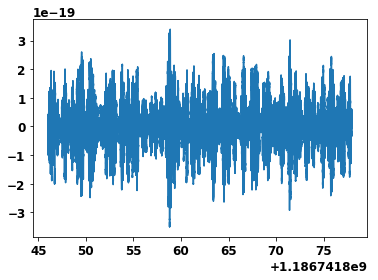

In [31]:
plt.plot(data.sample_times, data)

Text(0.5,1,'PSD for random gaussian noise')

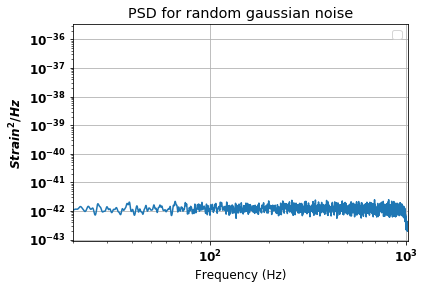

In [32]:
#to be coherant, we resample the noise in the same way rhe data has been resampled.

ts = white.highpass_fir(15,512)
resamp_noise = resample_to_delta_t(ts, 1.0/2048)
resamp_noise = resamp_noise.crop(2,2)

p = resamp_noise.psd(2)
p = interpolate(p, resamp_noise.delta_f)
p = inverse_spectrum_truncation(p, 2*resamp_noise.sample_rate, low_frequency_cutoff = 15.0)
psd_noise = p


plt.loglog(psd_noise.sample_frequencies, psd_noise)
plt.xlim(20,1024)
plt.ylabel("$Strain^2 / Hz$")
plt.xlabel("Frequency (Hz)")
plt.grid()
plt.legend()
plt.title("PSD for random gaussian noise")


When doing this, we see that there is no increase in the PSD for the highest and lowest frequencies. Moreoever, we see the result of Welch's method through the density of the sampling in frequencies that happens, with a higher density of frequency population for the highest frequencies present in the signal. 

Based on this PSD, we will experiment two different things: first, we will do the analys of the normal data (hence for the strain that is present in the detector for the GW170814 event) and see what happens. After that, we will reinject the optimal template that has been found previously to the noise and we will see if we have the possibility to retrieve it with the normal matched filtering techinque and what is the behaviour of the SNR in such a case.

In [33]:
data = m.strain('L1').highpass_fir(15,512)
data= resample_to_delta_t(data, 1.0/2048)
data = data.crop(2,2)

#make waveform
hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=data.delta_f, f_final=739.0645)
hp.resize(len(psd_noise))
template=hp.cyclic_time_shift(hp.start_time)

We found a signal at 1186741856.2470703s with a SNR of 0.1544419 in the L1 detector, when the PSD is taken as noise


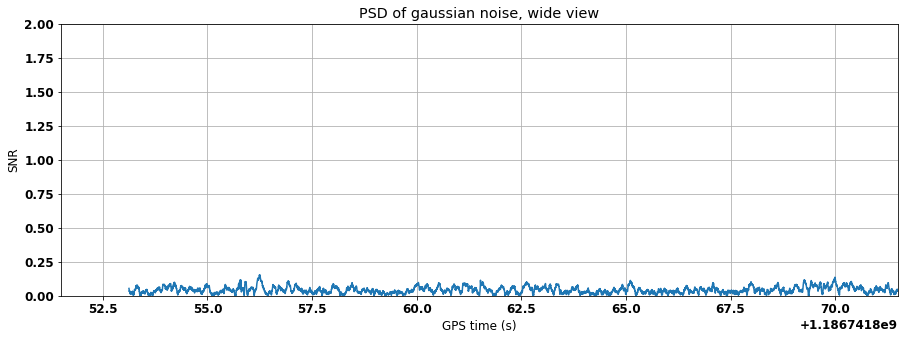

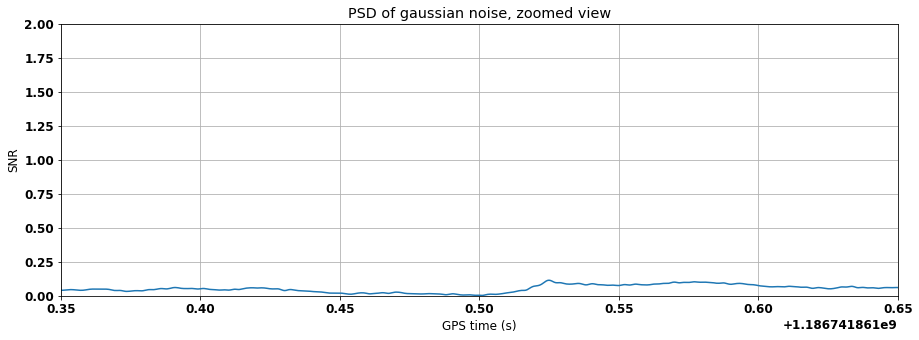

In [34]:
snr_noise = matched_filter(template, data, psd=psd_noise, low_frequency_cutoff = 15.0)
snr_noise = snr_noise.crop(5,4)

for w, title in ([10, 'PSD of gaussian noise, wide view'], [0.15, 'PSD of gaussian noise, zoomed view']):
    plt.figure(figsize=[15,5])
    plt.plot(snr_noise.sample_times, abs(snr_noise))
    if w==10 :
        peak = abs(snr_noise).numpy().argmax()
        snrp = snr_noise[peak]
        time = snr_noise.sample_times[peak]
        print("We found a signal at %.7fs with a SNR of %.7f in the L1 detector, when the PSD is taken as noise" %(time, abs(snrp)))
    plt.grid()
    plt.title(title)
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,2)
    plt.xlabel("GPS time (s)")
    plt.ylabel("SNR")

There is nothing that is found in this case. This shows that the purely Gaussian noise is not accounting for the properties of the noise that is present in the detector. Indeed, when the analysis  is done for a real event and that the noise is a random gaussian noise series, the noise is not well represented and the matched filtering is not efficient at all.

We can than look how well the matched filtering perform in the case where the noise really is a gaussian random series and the is a signal hidden in it. Therefore, we take our gaussian noise that has been generated and add the best fit template that has been found earlier to it. Based on that, we can redo the analysis for this mock event.


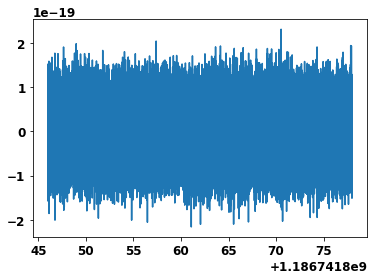

In [41]:
from pycbc.catalog import Merger
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
from pycbc.types import TimeSeries 
import numpy as np
from pycbc.psd import interpolate, inverse_spectrum_truncation


m=Merger("GW170814")

data = m.strain('L1')
#vector of the times that corresponds to those present in the 
#time series that are analyzed
times = data.sample_times
#fix the seed to keep the same noise present
np.random.seed(seed=12)
norm = scipy.stats.norm(0,0.5*10e-20)
white = norm.rvs(len(times))
white = TimeSeries(white, delta_t = 1.0/4096, epoch = data.start_time)
plt.plot(times, white)

In [42]:
#make a series of white noises to see if it is the amplitude of the noise that makes the signal unfidable
std_dev = [0.5*10e-30, 10e-30, 0.5*10e-29, 10e-29, 0.5*10e-28, 10e-28, 0.5*10e-27, 10e-27, 0.5*10e-26, 10e-26, 0.5*10e-25, 
          10e-25, 0.5*10e-24, 10e-24, 0.5*10e-23, 10e-23, 0.5*10e-22, 10e-22, 0.5*10e-21, 10e-21, 0.5*10e-20]
np.random.seed(seed=12)

whites = []

for i in range(len(std_dev)):
    gauss = scipy.stats.norm(0, std_dev[i])
    white = gauss.rvs(len(times))
    white = TimeSeries(white, delta_t = 1.0/4096, epoch = data.start_time)
    whites.append(white)

In [43]:
noisyGW = []
for i in range(len(whites)):
    noisyGW.append(whites[i]+best_fit_template)

In [44]:
GWdata = []
for i in range(len(noisyGW)):
    ts = noisyGW[i].highpass_fir(15,512)
    ts2 = resample_to_delta_t(ts, 1.0/2048)
    ts2 = ts2.crop(2,2)
    GWdata.append(ts2)

28417


Text(0.5,1,'PSD for random gaussian noise')

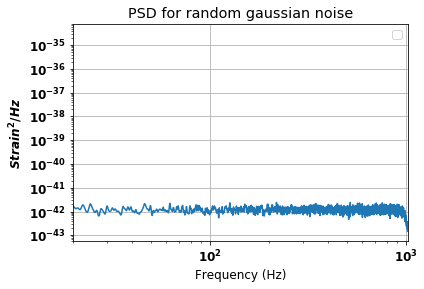

In [45]:
psds = []

for i in range(len(GWdata)):
    p = GWdata[i].psd(2)
    p = interpolate(p, GWdata[i].delta_f)
    p = inverse_spectrum_truncation(p, 2*GWdata[i].sample_rate, low_frequency_cutoff = 15.0)
    psds.append(p)
    
print(len(psds[i]))
plt.loglog(psds[i].sample_frequencies, psds[i])
plt.xlim(20,1024)
plt.ylabel("$Strain^2 / Hz$")
plt.xlabel("Frequency (Hz)")
plt.grid()
plt.legend()
plt.title("PSD for random gaussian noise")

In [46]:
temps = []

for i in range(len(GWdata)):
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=GWdata[i].delta_f, f_final=739.0645)
    hp.resize(len(psds[i]))
    template=hp.cyclic_time_shift(hp.start_time)
    temps.append(template)

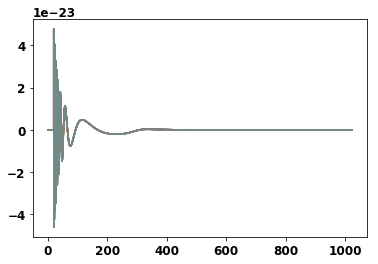

In [47]:
j=1
for i in range(len(temps)):
    plt.plot(temps[i].sample_frequencies, temps[i], alpha = j)
    j=j-0.04

In [48]:
noisy_snr = []

for i in range(len(GWdata)):
    snrN = matched_filter(temps[i], GWdata[i], psd=psds[i], low_frequency_cutoff = 15.0)
    snrN = snrN.crop(5,4)
    noisy_snr.append(snrN)
    

Found a signal at 1186741861.5249023 with a SNR of 1383596218.8368816 in the L1 detector, when std dev is 5.00e-30
Found a signal at 1186741861.5249023 with a SNR of 694594674.8016509 in the L1 detector, when std dev is 1.00e-29
Found a signal at 1186741861.5249023 with a SNR of 139971257.6705642 in the L1 detector, when std dev is 5.00e-29
Found a signal at 1186741861.5249023 with a SNR of 72577583.5834799 in the L1 detector, when std dev is 1.00e-28
Found a signal at 1186741861.5249023 with a SNR of 13527108.9665014 in the L1 detector, when std dev is 5.00e-28
Found a signal at 1186741861.5249023 with a SNR of 6748565.2437779 in the L1 detector, when std dev is 1.00e-27
Found a signal at 1186741861.5249023 with a SNR of 1371078.9082394 in the L1 detector, when std dev is 5.00e-27
Found a signal at 1186741861.5249023 with a SNR of 718772.4873910 in the L1 detector, when std dev is 1.00e-26
Found a signal at 1186741861.5249023 with a SNR of 142006.7135854 in the L1 detector, when std d

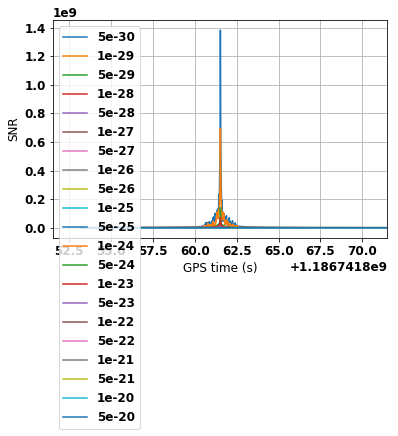

In [49]:
snrps = []
times = []

for i in range(len(GWdata)):
    plt.plot(noisy_snr[i].sample_times, abs(noisy_snr[i]), label=std_dev[i])
    peak = abs(noisy_snr[i]).numpy().argmax()
    snrp = noisy_snr[i][peak]
    time = noisy_snr[i].sample_times[peak]
    snrps.append(snrp)
    times.append(time)
    print("Found a signal at %.7F with a SNR of %.7f in the L1 detector, when std dev is %.2e" %(time, abs(snrp), std_dev[i]))
plt.grid()
plt.xlim(m.time-10, m.time+10)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend(loc='best')

(0, 100)

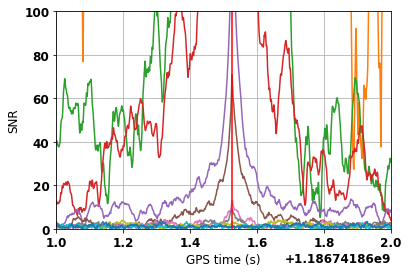

In [50]:
for i in range(len(GWdata)):
    plt.plot(noisy_snr[i].sample_times, abs(noisy_snr[i]), label=std_dev[i])
plt.grid()
plt.xlim(m.time-0.5, m.time+0.5)
plt.axvline(1186741861.5253906, color='red')
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.ylim(0,100)

Text(0,0.5,'value of the SNR')

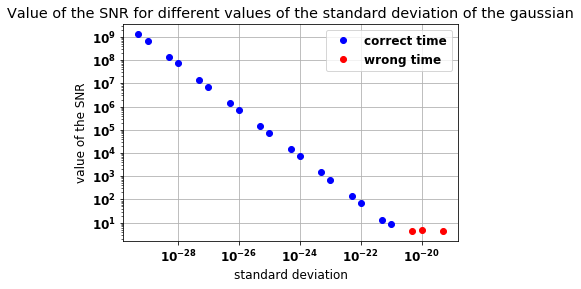

In [51]:
k =1
l=1
for i in range(len(std_dev)):
    if int(times[i]) != 1186741861:
        if k==1:
            plt.loglog(std_dev[i], abs(snrps[i]), 'or', label='wrong time')
            k = 12
        else:
            plt.loglog(std_dev[i], abs(snrps[i]), 'or')
    else:
        if l == 1:
            plt.loglog(std_dev[i], abs(snrps[i]), 'ob', label = 'correct time')
            l = 12
        else:
            plt.loglog(std_dev[i], abs(snrps[i]), 'ob')
        
            
plt.grid()
plt.legend(loc='best')
plt.title("Value of the SNR for different values of the standard deviation of the gaussian")
plt.xlabel("standard deviation")
plt.ylabel("value of the SNR")

The power spectrum of white noise is a constant that corresponds to the std deviation. So, it goes out of the integral and the since we used power of 10, it explains the relation

## Noise built based on the PSD

Above, the data has been build such that we have perfect white noise with a random generator taking the data out from a random gaussian population. Now, it is also possible how the behaviour would be depanding on the amplitude in the case where the noise is generated from the PSD of the signal. After that, we can look how the SNR varies based on the amplitude of the noise that has been generated in that way.

Function : pycbc.noise.gaussian.noise_from_psd

This function will provide a coloured noise which is build based on the PSD. This returns a series in frequency that has the same lenght and frequency step than the PSD that is provided

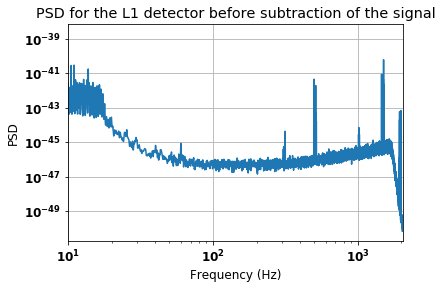

In [52]:
m = Merger("GW170814")
L1_strain = m.strain("L1")

#L1 strain highpassed
data = L1_strain.highpass_fir(10,512)

#Making the PSD from which the noise will be computed

f_low = 20
f_up = 1024


psd = data.psd(4)
psd = interpolate(psd, data.delta_f)
psd = inverse_spectrum_truncation(psd, 4*data.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

#plot of the PSD
plt.loglog(fs, psd)
plt.xlim(10, 2048)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD for the L1 detector before subtraction of the signal")
plt.grid()


Instead of building the noise directly from the PSD where the signal is included, we will build the PSD for the subtracted signal. So, we are sure that the noise that has been build does not contain some characteristics of the signal that is studied.

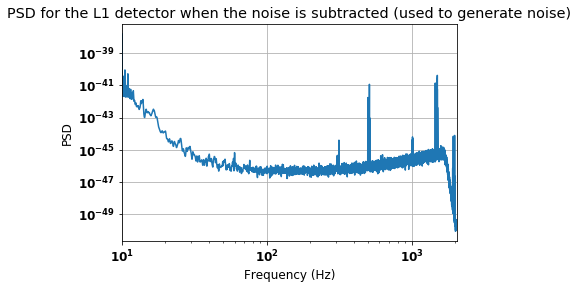

In [53]:
sub_data = ts_liv - best_fit_template 



psd_sub = sub_data.psd(4)
psd_sub = interpolate(psd_sub, sub_data.delta_f)
psd_sub = inverse_spectrum_truncation(psd_sub, 4*sub_data.sample_rate)

fs = psd_sub.delta_f * np.arange(psd_sub.data.size)

plt.loglog(fs, psd_sub)
plt.xlim(10,2048)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD for the L1 detector when the noise is subtracted (used to generate noise)")
plt.grid()

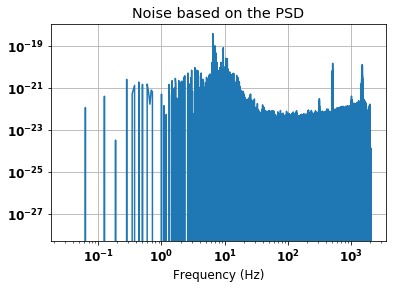

In [54]:
#noise generation based in the PSD where the noise has been suvtracted
from pycbc.noise import gaussian as gs
#fixed seed to keep the same noise generated each time
noise = gs.frequency_noise_from_psd(psd_sub, seed = 12) 

plt.loglog(noise.sample_frequencies, noise)
plt.title("Noise based on the PSD")
plt.xlabel("Frequency (Hz)")
plt.grid()

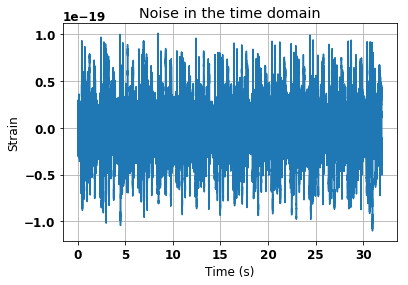

In [55]:
noise_time = noise.to_timeseries()

plt.plot(noise_time.sample_times, noise_time)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Noise in the time domain")
plt.grid()

Text(0.5,1,'Noise in the time domain with and without multiplicative constant')

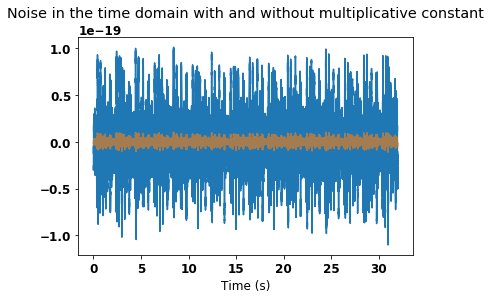

In [56]:
#check that multpilicative event is enough to have the required variation

noise_t_low = noise_time*0.1

plt.plot(noise_time.sample_times, noise_time, label="Normal noise")
plt.plot(noise_t_low.sample_times, noise_t_low, alpha=0.6, label='Noise*0.1')
plt.xlabel("Time (s)")
plt.title("Noise in the time domain with and without multiplicative constant", pad=20)

First, we will do a simple analysis for the noise that directly comes out of the noise produced by the function. After that, we will look what happens when we let the amplitude vary from a value that is a bit higher to a much lower value and see if the behaviour is as well marked as that of the gaussian noise.

In [57]:
noise = TimeSeries(noise_time, delta_t = 1.0/4096, epoch = best_fit_template.start_time)

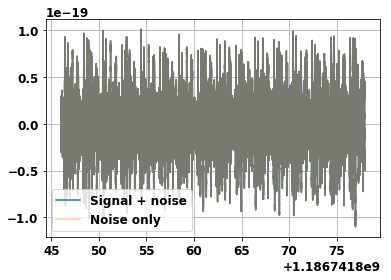

In [58]:
NoisySig = noise + best_fit_template

#visualisation of the noise, with the signal added
plt.plot(NoisySig.sample_times, NoisySig, label = 'Signal + noise')
plt.plot(noise.sample_times, noise, alpha= 0.4, label = 'Noise only')
plt.legend(loc='best')
plt.grid()


Text(0.5,1,'PSD for data + noise from the psd')

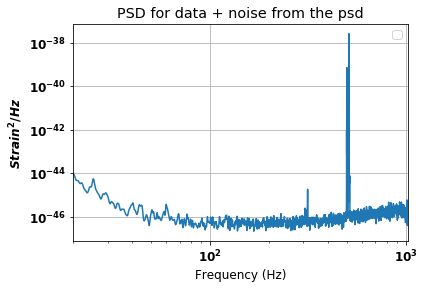

In [59]:
#Do the analysis based on this signal and noise that have been built
NoisySig = NoisySig.highpass_fir(15,512)
NoisySig = resample_to_delta_t(NoisySig, 1.0/2048)
NoisySig = NoisySig.crop(2,2)

psd = NoisySig.psd(2)
psd = interpolate(psd, NoisySig.delta_f)
psd = inverse_spectrum_truncation(psd, 2*NoisySig.sample_rate, low_frequency_cutoff = 15.0)

plt.loglog(psd.sample_frequencies, psd)
plt.xlim(20,1024)
plt.ylabel("$Strain^2 / Hz$")
plt.xlabel("Frequency (Hz)")
plt.grid()
plt.legend()
plt.title("PSD for data + noise from the psd")

Text(0.5,1,'Comparison PSD for noise only and PSD for noise and signal')

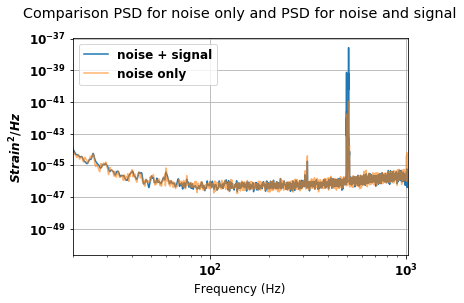

In [60]:
plt.loglog(psd.sample_frequencies, psd, label = 'noise + signal')
plt.loglog(psd_sub.sample_frequencies, psd_sub, alpha= 0.6, label = 'noise only')
plt.xlim(20,1024)
plt.ylabel("$Strain^2 / Hz$")
plt.xlabel("Frequency (Hz)")
plt.grid()
plt.legend()
plt.title("Comparison PSD for noise only and PSD for noise and signal", pad = 20)

In [61]:
#make template

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=NoisySig.delta_f, f_final=739.0645)
hp.resize(len(psd))
template=hp.cyclic_time_shift(hp.start_time)

We found a signal at 1186741861.5244141 with a SNR of 12.6511900 in this case


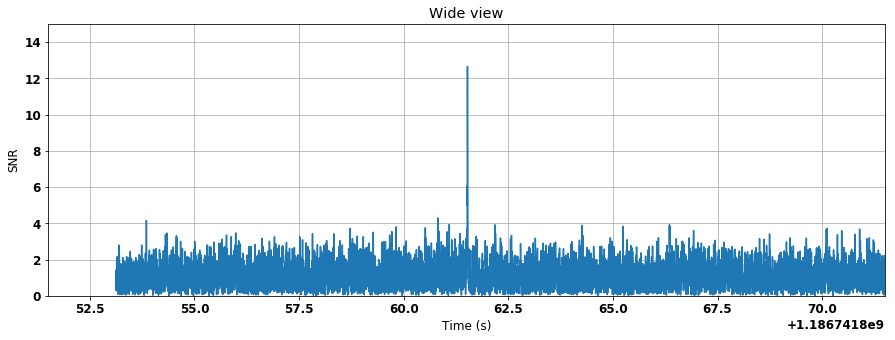

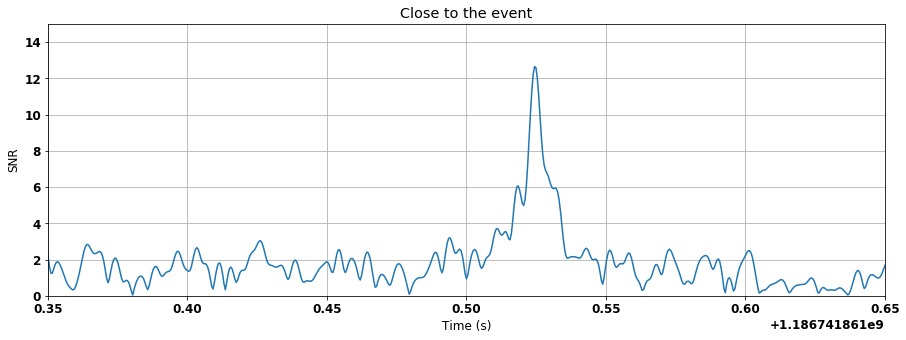

In [62]:
#make the SNR
snr = matched_filter(template, NoisySig, psd = psd, low_frequency_cutoff = 15.0)
snr = snr.crop(5,4)

for width, title in [(10, 'Wide view'), (.15, 'Close to the event')]:
    plt.figure(figsize=[15,5])
    plt.plot(snr.sample_times, abs(snr))
    if width == 10:
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]
        print("We found a signal at %.7f with a SNR of %.7f in this case" %(time, abs(snrp)))
    plt.title(title)
    plt.grid()
    plt.xlim(m.time - width, m.time + width)
    plt.ylim(0,15)
    plt.xlabel("Time (s)")
    plt.ylabel("SNR")


There is no notable difference in the SNR when it is simly re-added to the noise computed from the psd

Now we can look at how it evolves with the **amplitude of the noise**. We will take a signal that goes from an ampltiude of 100x that of the noise found in the detector to 0.001x the amplitude by step of 0.5.

In [63]:
#characterstics of the amplitude
maxx = noise_time.numpy().argmax()
minn= noise_time.numpy().argmin()
amplitude = noise_time[maxx] - noise_time[minn]
print(amplitude/2)

1.0541371967303521e-19


In [64]:
#new noise
noise = gs.frequency_noise_from_psd(psd_sub, seed = 122)
noise_time = noise.to_timeseries()
noise_time = TimeSeries(noise_time, delta_t = 1.0/4096, epoch = best_fit_template.start_time)

In [65]:
factors = [100, 15, 10, 1.5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 
           0.0005, 0.0001]

noises = [factors[i]*noise_time for i in range(len(factors))]

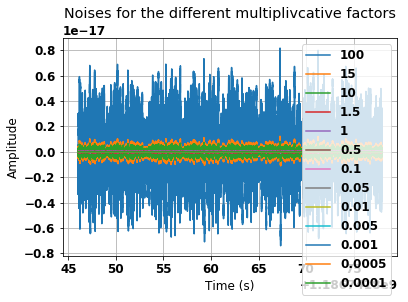

In [66]:
for i in range(len(noises)):
    plt.plot(noises[i].sample_times, noises[i], label= factors[i])
plt.title("Noises for the different multiplivcative factors", pad = 20)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

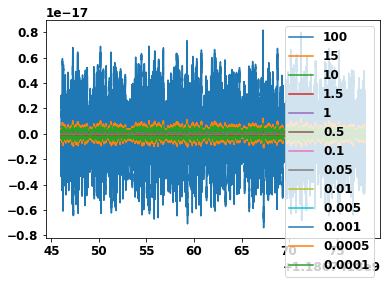

In [67]:
#make data
signals = []

for i in range(len(noises)):
    sig = noises[i] + best_fit_template
    signals.append(sig)


for i in range(len(signals)):
    plt.plot(signals[i].sample_times, signals[i], label = factors[i])
plt.legend(loc='best')

In [68]:
#prepare the data
for i in range(len(signals)):
    signals[i] = signals[i].highpass_fir(15,512)
    signals[i] = resample_to_delta_t(signals[i], 1.0/2048)
    signals[i] = signals[i].crop(2,2)

(20, 2048)

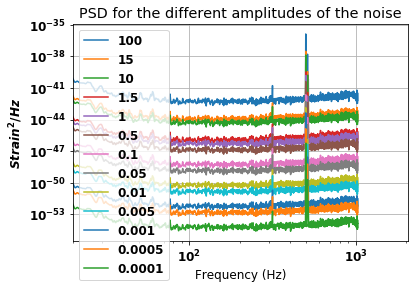

In [69]:
#building the PSD's
psds = []

for i in range(len(signals)):
    p = signals[i].psd(2)
    p = interpolate(p, signals[i].delta_f)
    p = inverse_spectrum_truncation(p, 2*signals[i].sample_rate, 
                                   low_frequency_cutoff = 15.0)
    psds.append(p)

#visualisation of all the psds, in order to compare

for i in range(len(psds)):
    plt.loglog(psds[i].sample_frequencies, psds[i], label=factors[i])
plt.xlabel("Frequency (Hz)")
plt.ylabel("$Strain^2 / Hz$")
plt.grid()
plt.title('PSD for the different amplitudes of the noise')
plt.legend()
plt.xlim(20,2048)

In [70]:
#make the templates
temps = []
for i in range(len(noises)):
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=signals[i].delta_f, f_final=739.0645)
    hp.resize(len(psds[i]))
    template=hp.cyclic_time_shift(hp.start_time)
    temps.append(template)

In [71]:
#compute the SNR for the different cases

Nsnrs = []

for i in range(len(noises)):
    Nsnr = matched_filter(temps[i], signals[i], psd = psds[i], 
                          low_frequency_cutoff = 15.0)
    Nsnr = Nsnr.crop(5,4)
    Nsnrs.append(Nsnr)
    

Found a signal at 1186741861.5244141 with a SNR of 114793.6882207 when using a multiplicative factor of 0.0001
Found a signal at 1186741861.5244141 with a SNR of 23205.4481665 when using a multiplicative factor of 0.0005
Found a signal at 1186741861.5244141 with a SNR of 11635.6127868 when using a multiplicative factor of 0.0010
Found a signal at 1186741861.5244141 with a SNR of 2331.3632434 when using a multiplicative factor of 0.0050
Found a signal at 1186741861.5244141 with a SNR of 1166.5898582 when using a multiplicative factor of 0.0100
Found a signal at 1186741861.5244141 with a SNR of 237.5579367 when using a multiplicative factor of 0.0500
Found a signal at 1186741861.5244141 with a SNR of 119.8222743 when using a multiplicative factor of 0.1000
Found a signal at 1186741861.5244141 with a SNR of 24.3105099 when using a multiplicative factor of 0.5000
Found a signal at 1186741861.5244141 with a SNR of 12.3583324 when using a multiplicative factor of 1.0000
Found a signal at 118

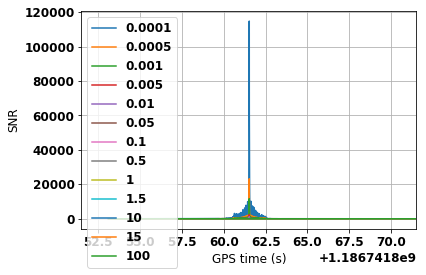

In [72]:
snrps = []
times = []

for i in range(len(Nsnrs)):
    k = len(Nsnrs) - (i+1)
    plt.plot(Nsnrs[k].sample_times, abs(Nsnrs[k]), label = factors[k])
    peak = abs(Nsnrs[k]).numpy().argmax()
    snrp = Nsnrs[k][peak]
    time = Nsnrs[k].sample_times[peak]
    snrps.append(snrp)
    times.append(time)
    print("Found a signal at %.7f with a SNR of %.7f when using a multiplicative factor of %.4f" 
          %(time, abs(snrp), factors[k]))
plt.grid()
plt.xlim(m.time-10, m.time+10)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend(loc='best')

x10, x15, x100 the peak that is found is not at the signal anymore and the event cannot be detected anymore

Text(0,0.5,'value of the SNR')

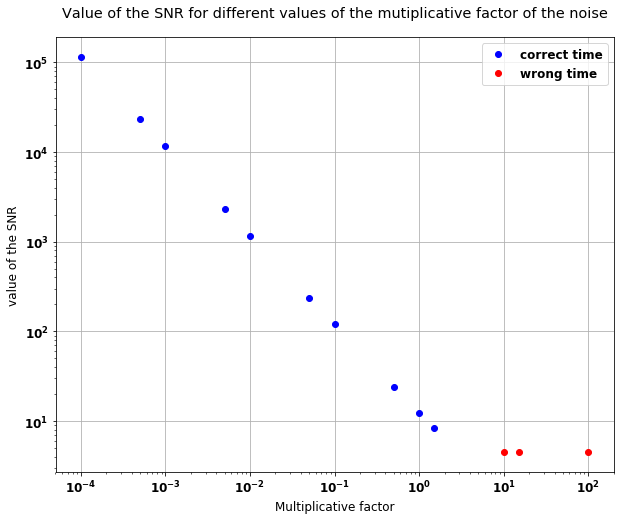

In [73]:
#made an inverse relation between the order of the factors and that of the
#snrps and times at the previous step

j = 1
l = 1
plt.figure(figsize=[10,8])

for i in range(len(factors)):
    k = len(Nsnrs) - (i+1)
    if times[i] > m.time+0.1 or times[i] < m.time-0.1:
        if j == 1:
            plt.loglog(factors[k], abs(snrps[i]), 'ro', label = 'wrong time')
            j = 12
        else:
            plt.loglog(factors[k], abs(snrps[i]), 'ro')
    else:
        if l == 1:
            plt.loglog(factors[k], abs(snrps[i]), 'bo', label = 'correct time')
            l = 12
        else:
            plt.loglog(factors[k], abs(snrps[i]), 'bo')
plt.grid()
plt.legend(loc='best')
plt.title("Value of the SNR for different values of the mutiplicative factor of the noise", pad = 20)
plt.xlabel("Multiplicative factor")
plt.ylabel("value of the SNR")

We see that the SNR increases exponentially with the decrease of the noise. However, if we compare that with what is obtained for white noise, we see that the highest value is less high that what we would have for the white noise.

This means that the SNR of a signal that has the current amplitude would be spotted much easier if we gain some factor on the noise. It could also mean that we could see signals with a lower amplitude, hence further away. 

We show this by dividing by 10 and 100 the amplitude of the best fit template and redoing the analysis. After that, we can also multiply the distances of the event, which also decreases the amplitude

In [74]:
#amplitude /10
noise = gs.frequency_noise_from_psd(psd_sub, seed = 122)
noise_time = noise.to_timeseries()
noise_time = TimeSeries(noise_time, delta_t = 1.0/4096, epoch = best_fit_template.start_time)

In [75]:
factors = [100, 15, 10, 1.5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 
           0.0005, 0.0001]

noises = [factors[i]*noise_time for i in range(len(factors))]

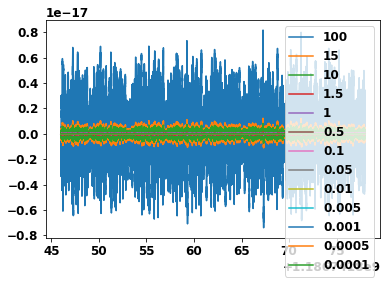

In [76]:
#make data
signals = []

for i in range(len(noises)):
    sig = noises[i] + ((best_fit_template)/10)
    signals.append(sig)


for i in range(len(signals)):
    plt.plot(signals[i].sample_times, signals[i], label = factors[i])
plt.legend(loc='best')

(20, 2048)

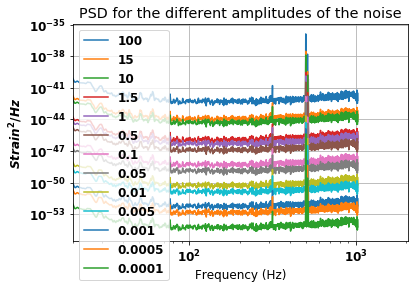

In [77]:
#prepare the data
for i in range(len(signals)):
    signals[i] = signals[i].highpass_fir(15,512)
    signals[i] = resample_to_delta_t(signals[i], 1.0/2048)
    signals[i] = signals[i].crop(2,2)
    
#building the PSD's
psds = []

for i in range(len(signals)):
    p = signals[i].psd(2)
    p = interpolate(p, signals[i].delta_f)
    p = inverse_spectrum_truncation(p, 2*signals[i].sample_rate, 
                                   low_frequency_cutoff = 15.0)
    psds.append(p)

#visualisation of all the psds, in order to compare

for i in range(len(psds)):
    plt.loglog(psds[i].sample_frequencies, psds[i], label=factors[i])
plt.xlabel("Frequency (Hz)")
plt.ylabel("$Strain^2 / Hz$")
plt.grid()
plt.title('PSD for the different amplitudes of the noise')
plt.legend()
plt.xlim(20,2048)

In [78]:
#make the templates
temps = []
for i in range(len(noises)):
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=signals[i].delta_f, f_final=739.0645)
    hp.resize(len(psds[i]))
    template=hp.cyclic_time_shift(hp.start_time)
    temps.append(template)

Found a signal at 1186741861.5244141 with a SNR of 11635.6127868 when using a multiplicative factor of 0.0001
Found a signal at 1186741861.5244141 with a SNR of 2331.3632434 when using a multiplicative factor of 0.0005
Found a signal at 1186741861.5244141 with a SNR of 1166.5898582 when using a multiplicative factor of 0.0010
Found a signal at 1186741861.5244141 with a SNR of 237.5579367 when using a multiplicative factor of 0.0050
Found a signal at 1186741861.5244141 with a SNR of 119.8222743 when using a multiplicative factor of 0.0100
Found a signal at 1186741861.5244141 with a SNR of 24.3105099 when using a multiplicative factor of 0.0500
Found a signal at 1186741861.5244141 with a SNR of 12.3583324 when using a multiplicative factor of 0.1000
Found a signal at 1186741853.5659180 with a SNR of 4.4970993 when using a multiplicative factor of 0.5000
Found a signal at 1186741853.5659180 with a SNR of 4.4938687 when using a multiplicative factor of 1.0000
Found a signal at 1186741853.5

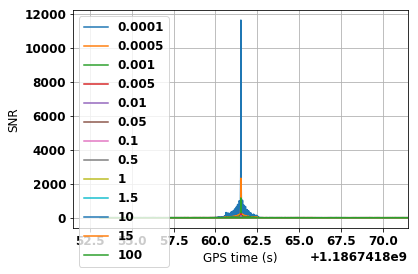

In [79]:
#compute the SNR for the different cases

Nsnrs = []

for i in range(len(noises)):
    Nsnr = matched_filter(temps[i], signals[i], psd = psds[i], 
                          low_frequency_cutoff = 15.0)
    Nsnr = Nsnr.crop(5,4)
    Nsnrs.append(Nsnr)
    
snrps = []
times = []

for i in range(len(Nsnrs)):
    k = len(Nsnrs) - (i+1)
    plt.plot(Nsnrs[k].sample_times, abs(Nsnrs[k]), label = factors[k])
    peak = abs(Nsnrs[k]).numpy().argmax()
    snrp = Nsnrs[k][peak]
    time = Nsnrs[k].sample_times[peak]
    snrps.append(snrp)
    times.append(time)
    print("Found a signal at %.7f with a SNR of %.7f when using a multiplicative factor of %.4f" 
          %(time, abs(snrp), factors[k]))
plt.grid()
plt.xlim(m.time-10, m.time+10)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend(loc='best')

Text(0,0.5,'value of the SNR')

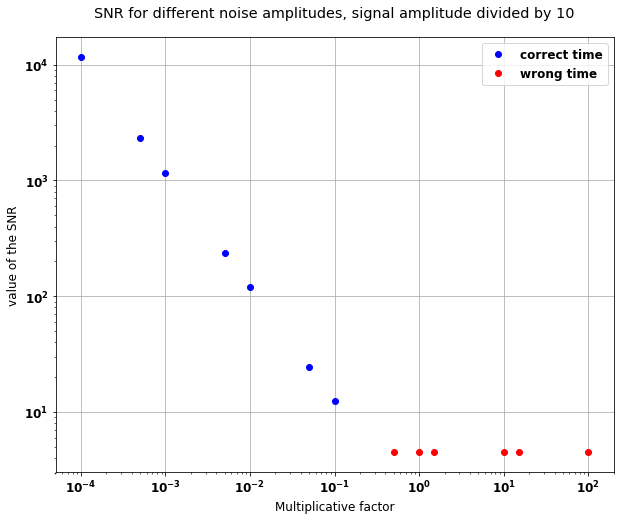

In [80]:
#made an inverse relation between the order of the factors and that of the
#snrps and times at the previous step

j = 1
l = 1

plt.figure(figsize=[10,8])

for i in range(len(factors)):
    k = len(Nsnrs) - (i+1)
    if times[i] > m.time+0.1 or times[i] < m.time-0.1:
        if j == 1:
            plt.loglog(factors[k], abs(snrps[i]), 'ro', label = 'wrong time')
            j = 12
        else:
            plt.loglog(factors[k], abs(snrps[i]), 'ro')
    else:
        if l == 1:
            plt.loglog(factors[k], abs(snrps[i]), 'bo', label = 'correct time')
            l = 12
        else:
            plt.loglog(factors[k], abs(snrps[i]), 'bo')
plt.grid()
plt.legend(loc='best')
plt.title("SNR for different noise amplitudes, signal amplitude divided by 10", pad = 20)
plt.xlabel("Multiplicative factor")
plt.ylabel("value of the SNR")

We see that a decrease by a factor 10 of the noise could anable to detect a signal with an amplitude 10x lower with an SNR similar to those observed nowadays.

### Amplitude of signal/100

In [81]:
noise = gs.frequency_noise_from_psd(psd_sub, seed = 122)
noise_time = noise.to_timeseries()
noise_time = TimeSeries(noise_time, delta_t = 1.0/4096, epoch = best_fit_template.start_time)

In [82]:
factors = [100, 15, 10, 1.5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 
           0.0005, 0.0001]

noises = [factors[i]*noise_time for i in range(len(factors))]

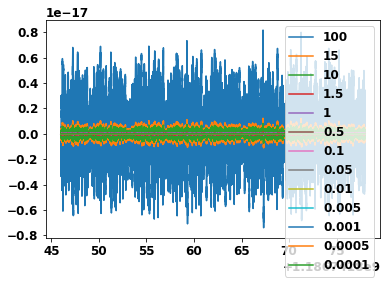

In [83]:
#make data
signals = []

for i in range(len(noises)):
    sig = noises[i] + ((best_fit_template)/100)
    signals.append(sig)


for i in range(len(signals)):
    plt.plot(signals[i].sample_times, signals[i], label = factors[i])
plt.legend(loc='best')

(20, 2048)

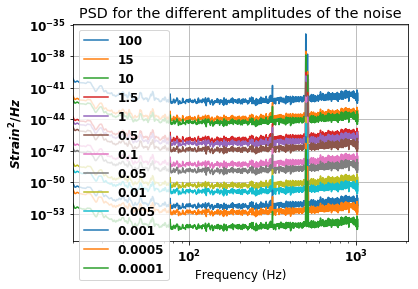

In [84]:
#prepare the data
for i in range(len(signals)):
    signals[i] = signals[i].highpass_fir(15,512)
    signals[i] = resample_to_delta_t(signals[i], 1.0/2048)
    signals[i] = signals[i].crop(2,2)
    
#building the PSD's
psds = []

for i in range(len(signals)):
    p = signals[i].psd(2)
    p = interpolate(p, signals[i].delta_f)
    p = inverse_spectrum_truncation(p, 2*signals[i].sample_rate, 
                                   low_frequency_cutoff = 15.0)
    psds.append(p)

#visualisation of all the psds, in order to compare

for i in range(len(psds)):
    plt.loglog(psds[i].sample_frequencies, psds[i], label=factors[i])
plt.xlabel("Frequency (Hz)")
plt.ylabel("$Strain^2 / Hz$")
plt.grid()
plt.title('PSD for the different amplitudes of the noise')
plt.legend()
plt.xlim(20,2048)

In [85]:
#make the templates
temps = []
for i in range(len(noises)):
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=signals[i].delta_f, f_final=739.0645)
    hp.resize(len(psds[i]))
    template=hp.cyclic_time_shift(hp.start_time)
    temps.append(template)

Found a signal at 1186741861.5244141 with a SNR of 1166.5898582 when using a multiplicative factor of 0.0001
Found a signal at 1186741861.5244141 with a SNR of 237.5579367 when using a multiplicative factor of 0.0005
Found a signal at 1186741861.5244141 with a SNR of 119.8222743 when using a multiplicative factor of 0.0010
Found a signal at 1186741861.5244141 with a SNR of 24.3105099 when using a multiplicative factor of 0.0050
Found a signal at 1186741861.5244141 with a SNR of 12.3583324 when using a multiplicative factor of 0.0100
Found a signal at 1186741853.5659180 with a SNR of 4.4970993 when using a multiplicative factor of 0.0500
Found a signal at 1186741853.5659180 with a SNR of 4.4938687 when using a multiplicative factor of 0.1000
Found a signal at 1186741853.5659180 with a SNR of 4.4809515 when using a multiplicative factor of 0.5000
Found a signal at 1186741853.5659180 with a SNR of 4.4819325 when using a multiplicative factor of 1.0000
Found a signal at 1186741853.5659180 

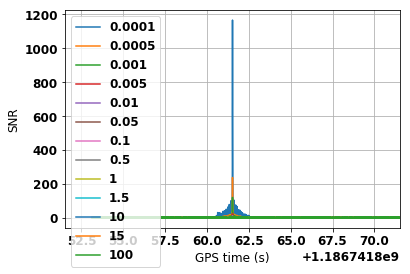

In [86]:
#compute the SNR for the different cases

Nsnrs = []

for i in range(len(noises)):
    Nsnr = matched_filter(temps[i], signals[i], psd = psds[i], 
                          low_frequency_cutoff = 15.0)
    Nsnr = Nsnr.crop(5,4)
    Nsnrs.append(Nsnr)
    
snrps = []
times = []

for i in range(len(Nsnrs)):
    k = len(Nsnrs) - (i+1)
    plt.plot(Nsnrs[k].sample_times, abs(Nsnrs[k]), label = factors[k])
    peak = abs(Nsnrs[k]).numpy().argmax()
    snrp = Nsnrs[k][peak]
    time = Nsnrs[k].sample_times[peak]
    snrps.append(snrp)
    times.append(time)
    print("Found a signal at %.7f with a SNR of %.7f when using a multiplicative factor of %.4f" 
          %(time, abs(snrp), factors[k]))
plt.grid()
plt.xlim(m.time-10, m.time+10)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend(loc='best')

Text(0,0.5,'value of the SNR')

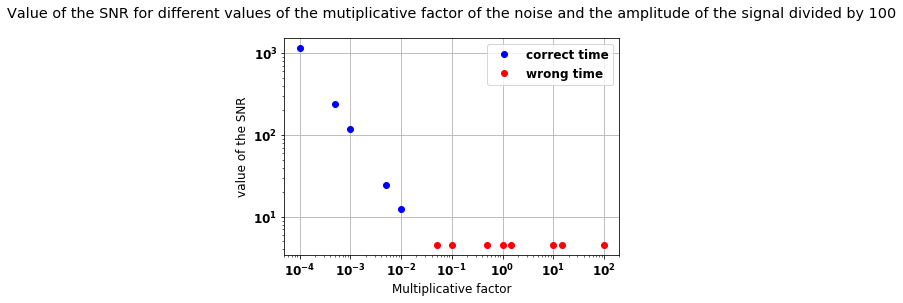

In [87]:
#made an inverse relation between the order of the factors and that of the
#snrps and times at the previous step

j = 1
l = 1

for i in range(len(factors)):
    k = len(Nsnrs) - (i+1)
    if times[i] > m.time+0.1 or times[i] < m.time-0.1:
        if j == 1:
            plt.loglog(factors[k], abs(snrps[i]), 'ro', label = 'wrong time')
            j = 12
        else:
            plt.loglog(factors[k], abs(snrps[i]), 'ro')
    else:
        if l == 1:
            plt.loglog(factors[k], abs(snrps[i]), 'bo', label = 'correct time')
            l = 12
        else:
            plt.loglog(factors[k], abs(snrps[i]), 'bo')
plt.grid()
plt.legend(loc='best')
plt.title("Value of the SNR for different values of the mutiplicative factor of the noise and the amplitude of the signal divided by 100", pad = 20)
plt.xlabel("Multiplicative factor")
plt.ylabel("value of the SNR")